# OCEAN Token Sentiment Analysis Challenge
## Data Exploration

## import

In [1]:
import os
import sys
from pathlib import Path
import re
import time
import math
from datetime import timedelta
from datetime import timezone
from datetime import datetime
import json

# Third Party
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
# from helpers.ocean_helpers import save_list
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()

## definitions

In [2]:
path_data = "data"
path_source_prices = os.path.join(path_data, "OCEAN token price dataset.csv")
path_source_tweets = os.path.join(path_data, "OCEAN tweets dataset.csv")

## Load raw data

In [3]:
df_raw_prices = pd.read_csv(path_source_prices)
df_raw_prices

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-05-06,0.030366,0.032274,0.029264,0.030010,0.030010,409704
1,2019-05-07,0.030004,0.034073,0.029316,0.032430,0.032430,444049
2,2019-05-08,0.032356,0.032356,0.027614,0.030407,0.030407,357657
3,2019-05-09,0.030359,0.031349,0.025541,0.027187,0.027187,328438
4,2019-05-10,0.027153,0.028078,0.023804,0.024751,0.024751,345215
...,...,...,...,...,...,...,...
1480,2023-05-25,0.327049,0.334983,0.318326,0.325028,0.325028,15927755
1481,2023-05-26,0.325024,0.346889,0.324414,0.346289,0.346289,21174463
1482,2023-05-27,0.346320,0.366628,0.345204,0.350783,0.350783,33179248
1483,2023-05-28,0.350814,0.365085,0.349344,0.358697,0.358697,18058566


In [4]:
df_raw_tweets = pd.read_csv(path_source_tweets)
df_raw_tweets

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1583608299085500416,1583289720846618627,2022-10-22 02:56:55 GTB (heure d’été),2022-10-22,02:56:55,300,1265742995636326401,mxyzptlk07,Mxyzptlk,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'JakeGagain', 'name': 'Jake G...",NaN,NaN,NaN,NaN
1,1583607565543669761,1583607565543669761,2022-10-22 02:54:00 GTB (heure d’été),2022-10-22,02:54:00,300,1265742995636326401,mxyzptlk07,Mxyzptlk,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
2,1583603064044367872,1583603064044367872,2022-10-22 02:36:07 GTB (heure d’été),2022-10-22,02:36:07,300,1319369787848405003,moonhodler2,MOONHODLER,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
3,1583598008511664128,1583595613903417344,2022-10-22 02:16:01 GTB (heure d’été),2022-10-22,02:16:01,300,3275094379,rjgaurav338,rikdbxs,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'CryptoGemsCom', 'name': 'The...",NaN,NaN,NaN,NaN
4,1583595987851173888,1583557616558833665,2022-10-22 02:07:59 GTB (heure d’été),2022-10-22,02:07:59,300,1258748447873806336,stringerbcoiner,StringerBitcoiner,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'cryptoworld202', 'name': 'Cr...",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229852,1211845595977019392,1211774284965859328,2019-12-31 05:04:39 GTB,2019-12-31,05:04:39,300,3307664430,mojo_crypto_btc,🦍🔥 ✧🔮 ጠዐጋዐ ƈཞ ⓨ ℘ɬዐ🔮✧ 🔥🦍 JNGL,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
229853,1211830366513901568,1211782150443479042,2019-12-31 04:04:08 GTB,2019-12-31,04:04:08,300,897905830334533632,harmoniccapital,Harmonic Capital,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'DaveCryptos', 'name': 'Dave ...",NaN,NaN,NaN,NaN
229854,1211818209738817536,1211818209738817536,2019-12-31 03:15:50 GTB,2019-12-31,03:15:50,300,999799024273141760,bakeobits,ShillSilverstein.kek 📈👑📉,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
229855,1211808120659300352,1211808120659300352,2019-12-31 02:35:44 GTB,2019-12-31,02:35:44,300,999799024273141760,bakeobits,ShillSilverstein.kek 📈👑📉,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN


## Clean Data

### Check data

In [5]:
def get_missing(df):
    nb_missing = df.isnull().sum()
    nb_missing = nb_missing.sort_values()
    nb_missing = nb_missing[nb_missing.values > 0]
    print("missing data : ")
    print(nb_missing)
    print("")
    print("on {} samples".format(df.shape[0]))
    return nb_missing


print("Check prices : ")
nb_missing = get_missing(df_raw_prices)

assert len(nb_missing)==0, "NaN value(s) in the prices!"
print("Prices ok")
df_prices = df_raw_prices.copy()

Check prices : 
missing data : 
Series([], dtype: int64)

on 1485 samples
Prices ok


In [6]:
print("Check tweets : ")
nb_missing = get_missing(df_raw_tweets)

Check tweets : 
missing data : 
name                18
thumbnail       172538
quote_url       198764
trans_src       229857
near            229857
geo             229857
source          229857
user_rt_id      229857
user_rt         229857
retweet_id      229857
place           229857
retweet_date    229857
translate       229857
trans_dest      229857
dtype: int64

on 229857 samples


In [7]:
def display_missing(df):
    '''
    Display dataFrame missing values : barplots & numbers
    ouput : dataFrame containing missing numbers
    '''
    nb_lignes = df.shape[0]
    nb_missing = df.isnull().sum()
    nb_missing = nb_missing.sort_values()
    df_missing = nb_missing.to_frame()
    df_missing.rename(index=str, columns={0: "nb_missing"}, inplace=True)
    df_missing["ratio"] = 100*df_missing["nb_missing"] / nb_lignes
    fig = plt.figure(figsize=(7, 7))
    liste_name_bars = df_missing.index.values
    liste_name_bars_num = []
    for name in liste_name_bars:
        liste_name_bars_num.append("{} [{}]".format(
            name, df_missing.loc[name, "nb_missing"]))
    ax = sns.barplot(y=liste_name_bars_num, x='ratio', data=df_missing)
    plt.title('Missing lines Ratio over {} lines'.format(nb_lignes))
    ax.set(xlabel='repartition [%]')
    ax.set_xlim([0, 100])
    return df_missing

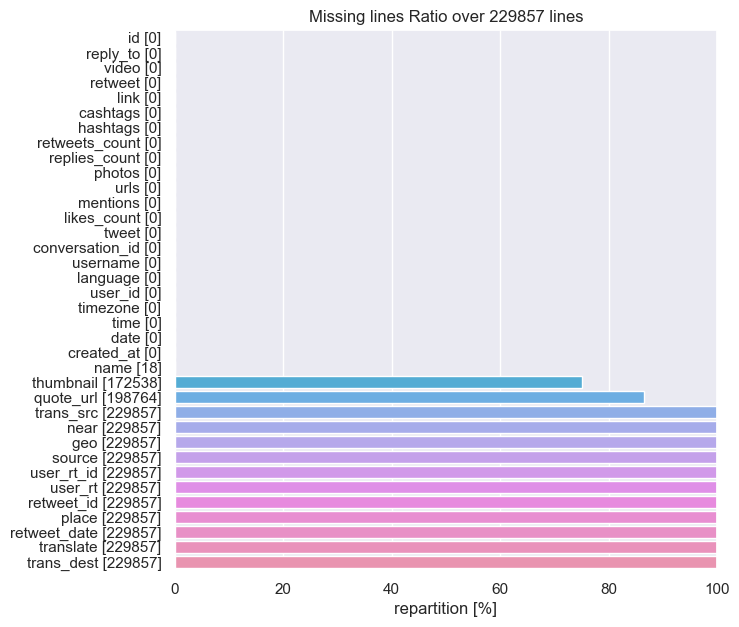

In [8]:
df_miss = display_missing(df_raw_tweets)

First strat, keep only columns where NaN values are < 90% of all values

In [9]:
list_col = df_miss[df_miss["ratio"] < 90].index.to_list()
list_col

['id',
 'reply_to',
 'video',
 'retweet',
 'link',
 'cashtags',
 'hashtags',
 'retweets_count',
 'replies_count',
 'photos',
 'urls',
 'mentions',
 'likes_count',
 'tweet',
 'conversation_id',
 'username',
 'language',
 'user_id',
 'timezone',
 'time',
 'date',
 'created_at',
 'name',
 'thumbnail',
 'quote_url']

In [10]:
df_tweets = df_raw_tweets[list_col].copy()
print("Check tweets : ")
nb_missing = get_missing(df_tweets)



Check tweets : 
missing data : 
name             18
thumbnail    172538
quote_url    198764
dtype: int64

on 229857 samples


In [11]:
df_tweets["quote_url"]

0                                                       NaN
1         https://twitter.com/oceanprotocol/status/15834...
2         https://twitter.com/oceanprotocol/status/15834...
3                                                       NaN
4                                                       NaN
                                ...                        
229852                                                  NaN
229853                                                  NaN
229854                                                  NaN
229855                                                  NaN
229856                                                  NaN
Name: quote_url, Length: 229857, dtype: object

In [12]:
df_tweets["thumbnail"] 

0                                                     NaN
1                                                     NaN
2                                                     NaN
3                                                     NaN
4         https://pbs.twimg.com/media/FfoQJTUWQAMjfYy.jpg
                               ...                       
229852                                                NaN
229853                                                NaN
229854                                                NaN
229855    https://pbs.twimg.com/media/ENE1D4GUYAAWcVh.jpg
229856                                                NaN
Name: thumbnail, Length: 229857, dtype: object

In [13]:
df_tweets["name"]

0                              Mxyzptlk
1                              Mxyzptlk
2                            MOONHODLER
3                               rikdbxs
4                     StringerBitcoiner
                      ...              
229852    🦍🔥 ✧🔮 ጠዐጋዐ ƈཞ ⓨ ℘ɬዐ🔮✧ 🔥🦍 JNGL
229853                 Harmonic Capital
229854         ShillSilverstein.kek 📈👑📉
229855         ShillSilverstein.kek 📈👑📉
229856                 Tycho Waterhouse
Name: name, Length: 229857, dtype: object

In [14]:
df_tweets["link"]

0         https://twitter.com/Mxyzptlk07/status/15836082...
1         https://twitter.com/Mxyzptlk07/status/15836075...
2         https://twitter.com/Moonhodler2/status/1583603...
3         https://twitter.com/rjgaurav338/status/1583598...
4         https://twitter.com/StringerBcoiner/status/158...
                                ...                        
229852    https://twitter.com/Mojo_Crypto_BTC/status/121...
229853    https://twitter.com/harmoniccapital/status/121...
229854    https://twitter.com/bakeobits/status/121181820...
229855    https://twitter.com/bakeobits/status/121180812...
229856    https://twitter.com/TychoWaterhouse/status/121...
Name: link, Length: 229857, dtype: object

### Time reference

Time reference between Prices & Tweets are not the same : 
- Prices seems to be in timezone UTC : on binance price open at 0.3506 and close 0.3581 on May 28th like data
- Tweet are UTC+3 time zone

We need to translate tweets date to UTC to be synchronized

In [15]:
df_tweets["timezone"].unique()

array([300])

In [16]:
df_tweets["date"]

0         2022-10-22
1         2022-10-22
2         2022-10-22
3         2022-10-22
4         2022-10-22
             ...    
229852    2019-12-31
229853    2019-12-31
229854    2019-12-31
229855    2019-12-31
229856    2019-12-31
Name: date, Length: 229857, dtype: object

In [17]:
df_tweets["link"][0]

'https://twitter.com/Mxyzptlk07/status/1583608299085500416'

In [18]:
df_tweets[df_tweets["date"] == "2022-06-01"].values[60]

array([1531975361663315970, '[]', 0, False,
       'https://twitter.com/hj_majeed7/status/1531975361663315970',
       "['ocean']", '[]', 2, 4, '[]', '[]', '[]', 9,
       '$OCEAN   THIS WEEK CAN BE A BIG WEEK FOR THIS COIN !   5-100% TARGET  SELL AT ANY PROPER PRICE',
       1531975361663315970, 'hj_majeed7', 'en', 1444718496924028942, 300,
       '15:26:03', '2022-06-01', '2022-06-01 15:26:03 GTB (heure d’été)',
       'HJMAJEED', nan, nan], dtype=object)

In [19]:
df_tweets["date"].max()

'2022-10-22'

In [20]:
df_prices

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-05-06,0.030366,0.032274,0.029264,0.030010,0.030010,409704
1,2019-05-07,0.030004,0.034073,0.029316,0.032430,0.032430,444049
2,2019-05-08,0.032356,0.032356,0.027614,0.030407,0.030407,357657
3,2019-05-09,0.030359,0.031349,0.025541,0.027187,0.027187,328438
4,2019-05-10,0.027153,0.028078,0.023804,0.024751,0.024751,345215
...,...,...,...,...,...,...,...
1480,2023-05-25,0.327049,0.334983,0.318326,0.325028,0.325028,15927755
1481,2023-05-26,0.325024,0.346889,0.324414,0.346289,0.346289,21174463
1482,2023-05-27,0.346320,0.366628,0.345204,0.350783,0.350783,33179248
1483,2023-05-28,0.350814,0.365085,0.349344,0.358697,0.358697,18058566


In [21]:
df_tweets.at[0, "date"]

'2022-10-22'

In [22]:
df_tweets.at[0, "time"]

'02:56:55'

In [23]:
date_str = '2023-02-15 16:00:00-05:00'
print(date_str)
date_str = pd.to_datetime(date_str, utc=True).strftime("%Y-%m-%dT%H:%M:%SZ")
print(date_str)

2023-02-15 16:00:00-05:00
2023-02-15T21:00:00Z


In [24]:
def fun_tweets_time(str_date):
    return " " + str_date + "+03:00"


df_tweets["time_utc"] = df_tweets["time"].copy().apply(fun_tweets_time)
df_tweets["time_utc"] = df_tweets["date"].copy() + df_tweets["time_utc"]
df_tweets["time_utc"] = pd.to_datetime(df_tweets["time_utc"], utc=True)
df_tweets["date_utc"] = df_tweets["time_utc"].dt.strftime("%Y-%m-%d")
df_tweets["time_utc"]

0        2022-10-21 23:56:55+00:00
1        2022-10-21 23:54:00+00:00
2        2022-10-21 23:36:07+00:00
3        2022-10-21 23:16:01+00:00
4        2022-10-21 23:07:59+00:00
                    ...           
229852   2019-12-31 02:04:39+00:00
229853   2019-12-31 01:04:08+00:00
229854   2019-12-31 00:15:50+00:00
229855   2019-12-30 23:35:44+00:00
229856   2019-12-30 23:34:52+00:00
Name: time_utc, Length: 229857, dtype: datetime64[ns, UTC]

In [25]:
df_tweets["date_utc"]

0         2022-10-21
1         2022-10-21
2         2022-10-21
3         2022-10-21
4         2022-10-21
             ...    
229852    2019-12-31
229853    2019-12-31
229854    2019-12-31
229855    2019-12-30
229856    2019-12-30
Name: date_utc, Length: 229857, dtype: object

### Time continuity

In [26]:
def fun_date_to_timestamp(str_date):
    return pd.Timestamp(str_date).timestamp()
df_prices["timestamp"] = df_prices["Date"].apply(fun_date_to_timestamp)

In [27]:
def test_time_continuity(df):
    try:
        #assert df.shape[0] == df.dropna().shape[0], "Some data are NaN !"
        diff_time = pd.to_datetime(df["timestamp"]).diff()
        assert np.max(diff_time) == np.min(diff_time), "Time gap!"

        return True
    
    except AssertionError as error:
        print(error)
        return False
    

assert test_time_continuity(df_prices), "No time continuity in prices!"
print("OK : prices for all calendar dates")

OK : prices for all calendar dates


In [28]:
df_tweets["timestamp"] = df_tweets["date_utc"].apply(fun_date_to_timestamp)
df_tweets["timestamp"]

0         1.666310e+09
1         1.666310e+09
2         1.666310e+09
3         1.666310e+09
4         1.666310e+09
              ...     
229852    1.577750e+09
229853    1.577750e+09
229854    1.577750e+09
229855    1.577664e+09
229856    1.577664e+09
Name: timestamp, Length: 229857, dtype: float64

<AxesSubplot: >

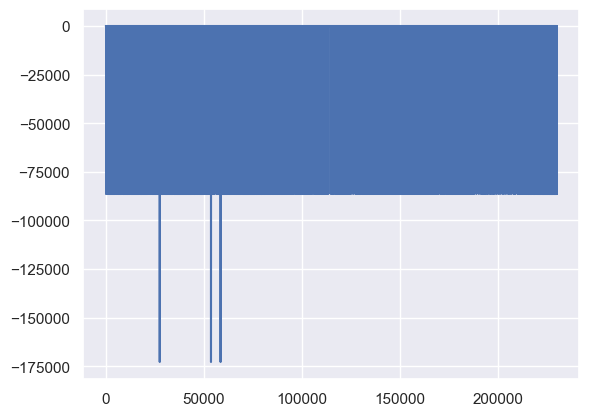

In [29]:
df_tweets["timestamp"].diff().plot()

In [30]:
np.sort(df_tweets["timestamp"])

array([1.5776640e+09, 1.5776640e+09, 1.5777504e+09, ..., 1.6663104e+09,
       1.6663104e+09, 1.6663104e+09])

In [31]:
ser_test_cont_tweet = pd.Series(np.diff((np.sort(df_tweets["timestamp"].unique())).astype(np.int64)) == 24*3600)
ser_test_cont_tweet.value_counts()

True     1020
False       3
dtype: int64

In [32]:
if  test_time_continuity(df_tweets) is False:
    print("No time continuity in df_tweets!")
    ser_test_cont_tweet = (df_tweets["timestamp"].diff() < -100000)
    print(ser_test_cont_tweet.value_counts())
else:
    print("OK : df_tweets for all calendar dates")

Time gap!
No time continuity in df_tweets!
False    229854
True          3
Name: timestamp, dtype: int64


## Calculate the correlation between the price of $OCEAN and the number of tweets containing "$OCEAN". 
What conclusions can be drawn from this correlation?

In [33]:
df_tweets

,id,reply_to,video,retweet,link,cashtags,hashtags,retweets_count,replies_count,photos,...,timezone,time,date,created_at,name,thumbnail,quote_url,time_utc,date_utc,timestamp
0,1583608299085500416,"[{'screen_name': 'JakeGagain', 'name': 'Jake G...",0,False,https://twitter.com/Mxyzptlk07/status/15836082...,['ocean'],"['data', 'web3']",0,0,[],...,300,02:56:55,2022-10-22,2022-10-22 02:56:55 GTB (heure d’été),Mxyzptlk,NaN,NaN,2022-10-21 23:56:55+00:00,2022-10-21,1.666310e+09
1,1583607565543669761,[],0,False,https://twitter.com/Mxyzptlk07/status/15836075...,['ocean'],"['datascientists', 'buidl', 'anewdataeconomy']",0,0,[],...,300,02:54:00,2022-10-22,2022-10-22 02:54:00 GTB (heure d’été),Mxyzptlk,NaN,https://twitter.com/oceanprotocol/status/15834...,2022-10-21 23:54:00+00:00,2022-10-21,1.666310e+09
2,1583603064044367872,[],0,False,https://twitter.com/Moonhodler2/status/1583603...,['ocean'],['data'],0,0,[],...,300,02:36:07,2022-10-22,2022-10-22 02:36:07 GTB (heure d’été),MOONHODLER,NaN,https://twitter.com/oceanprotocol/status/15834...,2022-10-21 23:36:07+00:00,2022-10-21,1.666310e+09
3,1583598008511664128,"[{'screen_name': 'CryptoGemsCom', 'name': 'The...",0,False,https://twitter.com/rjgaurav338/status/1583598...,"['ocean', 'bnb', 'eth']",[],0,0,[],...,300,02:16:01,2022-10-22,2022-10-22 02:16:01 GTB (heure d’été),rikdbxs,NaN,NaN,2022-10-21 23:16:01+00:00,2022-10-21,1.666310e+09
4,1583595987851173888,"[{'screen_name': 'cryptoworld202', 'name': 'Cr...",1,False,https://twitter.com/StringerBcoiner/status/158...,"['ocean', 'ltc', 'ngm', 'dafi', 'esek', 'enok'...","['ngm', 'dafi', 'ngm']",0,1,['https://pbs.twimg.com/media/FfoQJTUWQAMjfYy....,...,300,02:07:59,2022-10-22,2022-10-22 02:07:59 GTB (heure d’été),StringerBitcoiner,https://pbs.twimg.com/media/FfoQJTUWQAMjfYy.jpg,NaN,2022-10-21 23:07:59+00:00,2022-10-21,1.666310e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229852,1211845595977019392,[],0,False,https://twitter.com/Mojo_Crypto_BTC/status/121...,"['xrp', 'perl', 'nrg', 'ocean']",[],0,0,[],...,300,05:04:39,2019-12-31,2019-12-31 05:04:39 GTB,🦍🔥 ✧🔮 ጠዐጋዐ ƈཞ ⓨ ℘ɬዐ🔮✧ 🔥🦍 JNGL,NaN,NaN,2019-12-31 02:04:39+00:00,2019-12-31,1.577750e+09
229853,1211830366513901568,"[{'screen_name': 'DaveCryptos', 'name': 'Dave ...",0,False,https://twitter.com/harmoniccapital/status/121...,['ocean'],[],0,0,[],...,300,04:04:08,2019-12-31,2019-12-31 04:04:08 GTB,Harmonic Capital,NaN,NaN,2019-12-31 01:04:08+00:00,2019-12-31,1.577750e+09
229854,1211818209738817536,[],0,False,https://twitter.com/bakeobits/status/121181820...,"['ins', 'ocean', 'ins']",[],0,2,[],...,300,03:15:50,2019-12-31,2019-12-31 03:15:50 GTB,ShillSilverstein.kek 📈👑📉,NaN,NaN,2019-12-31 00:15:50+00:00,2019-12-31,1.577750e+09
229855,1211808120659300352,[],1,False,https://twitter.com/bakeobits/status/121180812...,['ocean'],[],0,2,['https://pbs.twimg.com/media/ENE1D4GUYAAWcVh....,...,300,02:35:44,2019-12-31,2019-12-31 02:35:44 GTB,ShillSilverstein.kek 📈👑📉,https://pbs.twimg.com/media/ENE1D4GUYAAWcVh.jpg,NaN,2019-12-30 23:35:44+00:00,2019-12-30,1.577664e+09


### Select data with cash tags

In [34]:
def fun_find_cash(list_str):
    return "ocean" in list_str
df_tweets["cash"] = df_tweets["cashtags"].apply(fun_find_cash)
df_tweets["cash"].value_counts()

True     229773
False        84
Name: cash, dtype: int64

In [35]:
df_tweets[["cash", "date_utc"]].groupby("date_utc").count()

,cash
date_utc,
2019-12-30,2
2019-12-31,35
2020-01-01,37
2020-01-02,52
2020-01-03,39
...,...
2022-10-17,157
2022-10-18,686
2022-10-19,273


Check if everyday a tweet with $OCEAN tags occurs

In [36]:
df_tweets[["cash", "date_utc"]].groupby("date_utc")

In [37]:
nb_dates = df_tweets["date_utc"].nunique()
print("nb_dates: ", nb_dates)
ser_nb_cash = df_tweets[
        ["cash", "date_utc"]
    ].groupby("date_utc",
    group_keys=False).apply(lambda x: np.any(x["cash"])).value_counts()
print(ser_nb_cash)
assert ser_nb_cash[True] == nb_dates, "NOT everyday, a tweet with $OCEAN tags occurs !"
print("OK :  everyday, a tweet with $OCEAN tags occurs !")

nb_dates:  1024
True    1024
dtype: int64
OK :  everyday, a tweet with $OCEAN tags occurs !


### Count nb tweets

In [38]:
df_nb_tweets = df_tweets[df_tweets["cash"] == True][["id", "date_utc"]].groupby("date_utc").count()
df_nb_tweets.rename(columns={"id":"nb_tweets"}, inplace=True)
df_nb_tweets

,nb_tweets
date_utc,
2019-12-30,2
2019-12-31,35
2020-01-01,37
2020-01-02,52
2020-01-03,38
...,...
2022-10-17,156
2022-10-18,686
2022-10-19,273


In [39]:
df_prices

,Date,Open,High,Low,Close,Adj Close,Volume,timestamp
0,2019-05-06,0.030366,0.032274,0.029264,0.030010,0.030010,409704,1.557101e+09
1,2019-05-07,0.030004,0.034073,0.029316,0.032430,0.032430,444049,1.557187e+09
2,2019-05-08,0.032356,0.032356,0.027614,0.030407,0.030407,357657,1.557274e+09
3,2019-05-09,0.030359,0.031349,0.025541,0.027187,0.027187,328438,1.557360e+09
4,2019-05-10,0.027153,0.028078,0.023804,0.024751,0.024751,345215,1.557446e+09
...,...,...,...,...,...,...,...,...
1480,2023-05-25,0.327049,0.334983,0.318326,0.325028,0.325028,15927755,1.684973e+09
1481,2023-05-26,0.325024,0.346889,0.324414,0.346289,0.346289,21174463,1.685059e+09
1482,2023-05-27,0.346320,0.366628,0.345204,0.350783,0.350783,33179248,1.685146e+09
1483,2023-05-28,0.350814,0.365085,0.349344,0.358697,0.358697,18058566,1.685232e+09


### Add insights about prices

In [40]:
df_prices

,Date,Open,High,Low,Close,Adj Close,Volume,timestamp
0,2019-05-06,0.030366,0.032274,0.029264,0.030010,0.030010,409704,1.557101e+09
1,2019-05-07,0.030004,0.034073,0.029316,0.032430,0.032430,444049,1.557187e+09
2,2019-05-08,0.032356,0.032356,0.027614,0.030407,0.030407,357657,1.557274e+09
3,2019-05-09,0.030359,0.031349,0.025541,0.027187,0.027187,328438,1.557360e+09
4,2019-05-10,0.027153,0.028078,0.023804,0.024751,0.024751,345215,1.557446e+09
...,...,...,...,...,...,...,...,...
1480,2023-05-25,0.327049,0.334983,0.318326,0.325028,0.325028,15927755,1.684973e+09
1481,2023-05-26,0.325024,0.346889,0.324414,0.346289,0.346289,21174463,1.685059e+09
1482,2023-05-27,0.346320,0.366628,0.345204,0.350783,0.350783,33179248,1.685146e+09
1483,2023-05-28,0.350814,0.365085,0.349344,0.358697,0.358697,18058566,1.685232e+09


In [41]:
df_prices["pc_var"] = 100 * ( df_prices["Close"]  - df_prices["Open"] ) / df_prices["Open"]
df_prices

,Date,Open,High,Low,Close,Adj Close,Volume,timestamp,pc_var
0,2019-05-06,0.030366,0.032274,0.029264,0.030010,0.030010,409704,1.557101e+09,-1.172364
1,2019-05-07,0.030004,0.034073,0.029316,0.032430,0.032430,444049,1.557187e+09,8.085589
2,2019-05-08,0.032356,0.032356,0.027614,0.030407,0.030407,357657,1.557274e+09,-6.023612
3,2019-05-09,0.030359,0.031349,0.025541,0.027187,0.027187,328438,1.557360e+09,-10.448302
4,2019-05-10,0.027153,0.028078,0.023804,0.024751,0.024751,345215,1.557446e+09,-8.846168
...,...,...,...,...,...,...,...,...,...
1480,2023-05-25,0.327049,0.334983,0.318326,0.325028,0.325028,15927755,1.684973e+09,-0.617950
1481,2023-05-26,0.325024,0.346889,0.324414,0.346289,0.346289,21174463,1.685059e+09,6.542594
1482,2023-05-27,0.346320,0.366628,0.345204,0.350783,0.350783,33179248,1.685146e+09,1.288693
1483,2023-05-28,0.350814,0.365085,0.349344,0.358697,0.358697,18058566,1.685232e+09,2.247060


Levels of price variation : level_stat_price :
- neutral : var mean - 1 std < var price < var mean + 1 std
- bearish : var price < var mean - std
- bullish : var price > var mean + std

In [42]:
list_level_stat_price = ["bearish", "neutral", "bullish"]
mean_pc_var = df_prices["pc_var"].mean()
print("mean_pc_var: ", mean_pc_var)
std_pc_var = df_prices["pc_var"].std()
print("std_pc_var: ", std_pc_var)

def fun_level_stat_price(pc_var):
    if (mean_pc_var - std_pc_var < pc_var) & (pc_var < (mean_pc_var + std_pc_var)):
        return "neutral"
    elif (mean_pc_var - std_pc_var > pc_var):
        return "bearish"
    else:
        return "bullish"
df_prices["level_stat_price"] = df_prices["pc_var"].apply(fun_level_stat_price)
df_prices["level_stat_price"].value_counts()

mean_pc_var:  0.5045419850808329
std_pc_var:  8.221292169357758


neutral    1153
bearish     166
bullish     166
Name: level_stat_price, dtype: int64

Another level more "in house" : level_price :
- normal : price var < 3+/- 3%
- decline : -7% < price var <= -3%
- fall : price var <= -7%
- rise : +7% > price var >= +3%
- surge : price var >= +7%

In [43]:
list_level_price = ["fall", "decline", "neutral", "rise", "surge"]
def fun_level_price(pc_var):
    if (-3 < pc_var) & (pc_var < 3):
        return "neutral"
    elif ( -7 < pc_var) & (pc_var <= -3):
        return "decline"
    elif ( pc_var <= -7):
        return "fall"  
    elif ( 7 > pc_var) & (pc_var >= 3):
        return "rise"            
    else:
        return "surge"

df_prices["level_price"] = df_prices["pc_var"].apply(fun_level_price)
df_prices["level_price"].value_counts()

neutral    574
decline    257
rise       241
surge      220
fall       193
Name: level_price, dtype: int64

### Add insights about nb tweets

In [44]:
df_nb_tweets

,nb_tweets
date_utc,
2019-12-30,2
2019-12-31,35
2020-01-01,37
2020-01-02,52
2020-01-03,38
...,...
2022-10-17,156
2022-10-18,686
2022-10-19,273


In [45]:
list_level_tweets = ["low_nb_tweet", "normal_nb_tweet", "high_nb_tweet"]
mean_nb_tweets = df_nb_tweets["nb_tweets"].mean()
print("mean_nb_tweets: ", mean_nb_tweets)
std_nb_tweets = df_nb_tweets["nb_tweets"].std()
print("std_nb_tweets: ", std_nb_tweets)
print("low_nb_tweet:")
print(f"0 - {mean_nb_tweets - std_nb_tweets/2}")
print("normal_nb_tweet:")
print(f"{mean_nb_tweets - std_nb_tweets/2} - {mean_nb_tweets + std_nb_tweets/2}")
print("high_nb_tweet:")
print(f"{mean_nb_tweets + std_nb_tweets/2} - inf")


def fun_level_nb_tweet(nb_tweets):
    if (mean_nb_tweets - std_nb_tweets/2 < nb_tweets) & (nb_tweets < (mean_nb_tweets + std_nb_tweets/2)):
        return "normal_nb_tweet"
    elif (mean_nb_tweets - std_nb_tweets/2 > nb_tweets):
        return "low_nb_tweet"
    else:
        return "high_nb_tweet"
df_nb_tweets["level_tweets"] = df_nb_tweets["nb_tweets"].apply(fun_level_nb_tweet)
df_nb_tweets["level_tweets"].value_counts()

mean_nb_tweets:  224.3876953125
std_nb_tweets:  205.75672764843276
low_nb_tweet:
0 - 121.50933148828362
normal_nb_tweet:
121.50933148828362 - 327.26605913671636
high_nb_tweet:
327.26605913671636 - inf


normal_nb_tweet    428
low_nb_tweet       365
high_nb_tweet      231
Name: level_tweets, dtype: int64

### merge data

In [46]:
df_nb = df_nb_tweets.merge(df_prices, how='inner', left_index=True, right_on='Date', suffixes=(False, False))
df_nb

,nb_tweets,level_tweets,Date,Open,High,Low,Close,Adj Close,Volume,timestamp,pc_var,level_stat_price,level_price
238,2,low_nb_tweet,2019-12-30,0.030096,0.033129,0.029338,0.032726,0.032726,11037407,1.577664e+09,8.738703,bullish,surge
239,35,low_nb_tweet,2019-12-31,0.032700,0.038978,0.032562,0.037197,0.037197,12297226,1.577750e+09,13.752294,bullish,surge
240,37,low_nb_tweet,2020-01-01,0.037197,0.039687,0.034801,0.039226,0.039226,12577450,1.577837e+09,5.454741,neutral,rise
241,52,low_nb_tweet,2020-01-02,0.039209,0.039322,0.034053,0.034784,0.034784,10414026,1.577923e+09,-11.285674,bearish,fall
242,38,low_nb_tweet,2020-01-03,0.034774,0.038628,0.034186,0.036693,0.036693,11271250,1.578010e+09,5.518491,neutral,rise
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1260,156,normal_nb_tweet,2022-10-17,0.150487,0.152528,0.148830,0.152231,0.152231,4791953,1.665965e+09,1.158904,neutral,neutral
1261,686,high_nb_tweet,2022-10-18,0.152237,0.199573,0.151643,0.167960,0.167960,86145727,1.666051e+09,10.327975,bullish,surge
1262,273,normal_nb_tweet,2022-10-19,0.167924,0.167924,0.160154,0.164779,0.164779,20414280,1.666138e+09,-1.872871,neutral,neutral
1263,226,normal_nb_tweet,2022-10-20,0.164792,0.167368,0.162250,0.165510,0.165510,10699438,1.666224e+09,0.435701,neutral,neutral


### Insights

In [47]:
df_nb.describe()

,nb_tweets,Open,High,Low,Close,Adj Close,Volume,timestamp,pc_var
count,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1.024000e+03,1.024000e+03,1024.000000
mean,224.387695,0.486282,0.515553,0.458556,0.486476,0.486476,3.423628e+07,1.621932e+09,0.481513
std,205.756728,0.389896,0.414562,0.367286,0.389883,0.389883,4.044728e+07,2.564096e+07,7.777951
min,1.000000,0.019931,0.024722,0.017603,0.020029,0.020029,1.632125e+06,1.577664e+09,-54.595069
25%,97.000000,0.165172,0.172069,0.159381,0.165168,0.165168,1.278643e+07,1.599761e+09,-3.833254
50%,157.000000,0.432268,0.454014,0.409697,0.432423,0.432423,2.317279e+07,1.621858e+09,0.345004
75%,293.250000,0.683909,0.732825,0.627980,0.683721,0.683721,4.386585e+07,1.644127e+09,4.250609
max,1326.000000,1.818558,1.941328,1.719507,1.817588,1.817588,5.525757e+08,1.666310e+09,55.099021


#### Close price

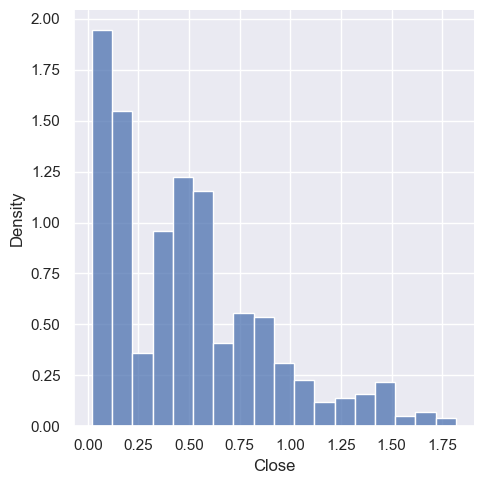

In [48]:
sns.displot(df_nb, x="Close",stat="density")

<AxesSubplot: xlabel='Close'>

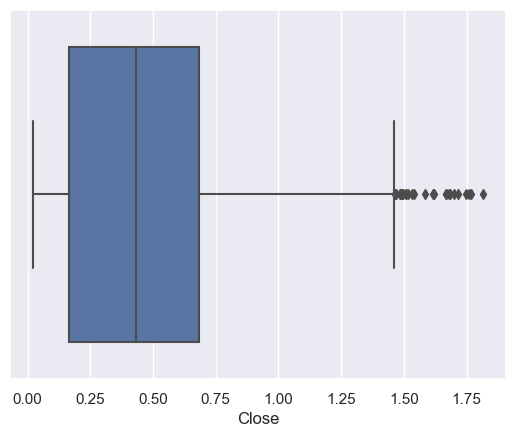

In [49]:
sns.boxplot(x=df_nb["Close"])

#### nb tweets

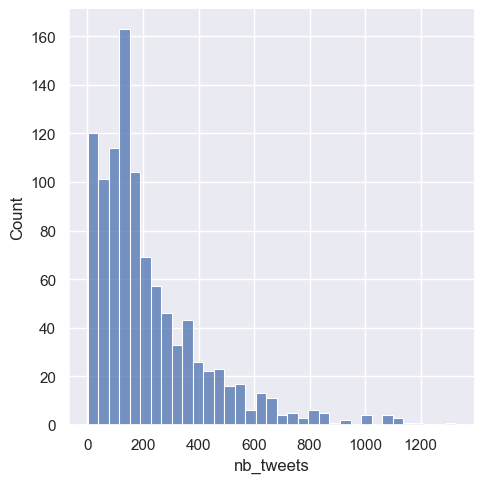

In [50]:
sns.displot(df_nb, x="nb_tweets")

<AxesSubplot: xlabel='nb_tweets'>

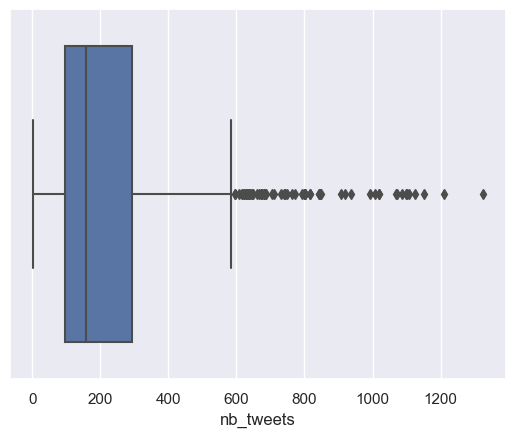

In [51]:
sns.boxplot(x=df_nb["nb_tweets"])

#### relation between Close price and nb tweets

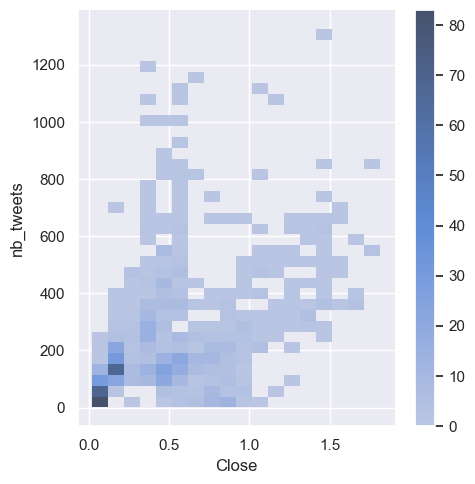

In [52]:
sns.displot(df_nb, x="Close", y="nb_tweets", cbar=True)

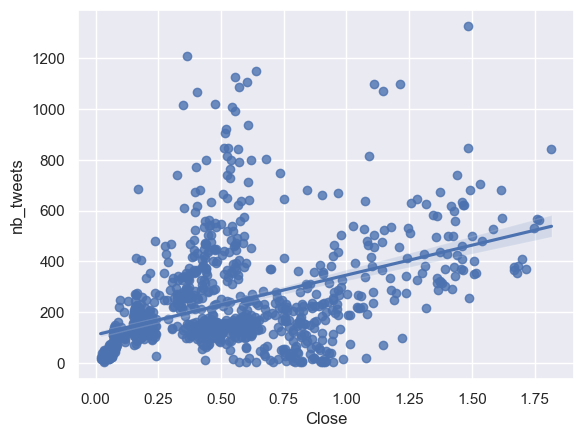

In [53]:
sns.regplot(x="Close", y="nb_tweets", data=df_nb);

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_87793/1150079040.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_nb.corr()


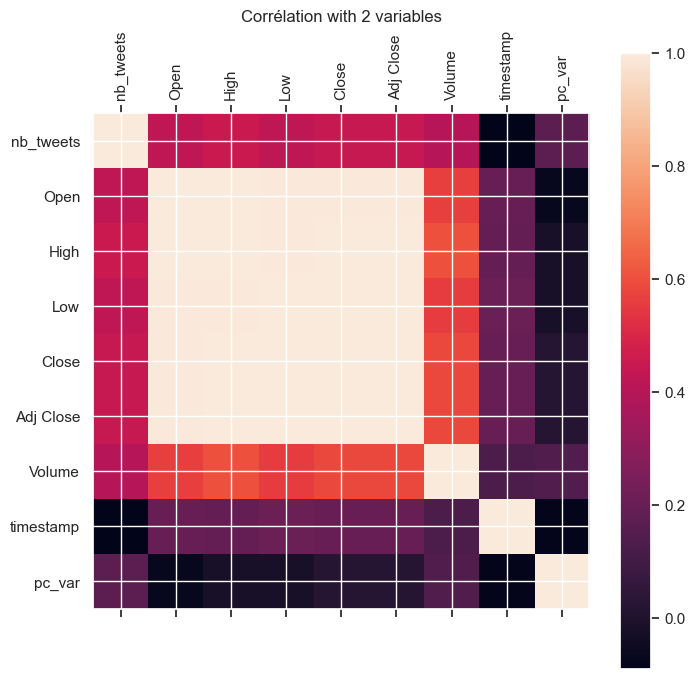

In [54]:
# Calculer la matrice de corrélation
corr_matrix = df_nb.corr()

# Afficher la matrice de corrélation
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.matshow(corr_matrix)
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.title('Corrélation with 2 variables')
fig.colorbar(im)
plt.show()

In [89]:
ser_month  = df_nb["nb_tweets"].rolling(30).sum()
ser_month

238        NaN
239        NaN
240        NaN
241        NaN
242        NaN
         ...  
1260    5208.0
1261    5760.0
1262    5854.0
1263    5835.0
1264    5876.0
Name: nb_tweets, Length: 1024, dtype: float64

#### Price variation in a day

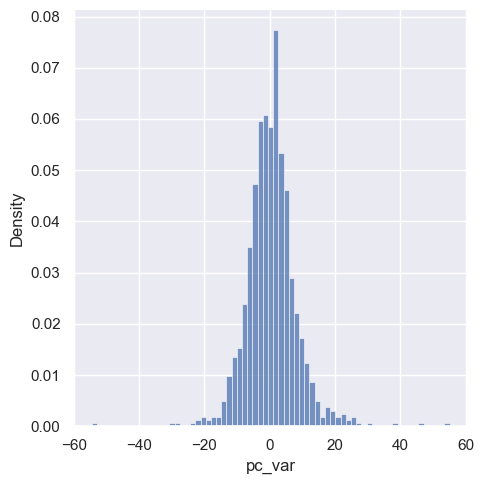

In [55]:
sns.displot(df_nb, x="pc_var",stat="density")

<AxesSubplot: xlabel='pc_var'>

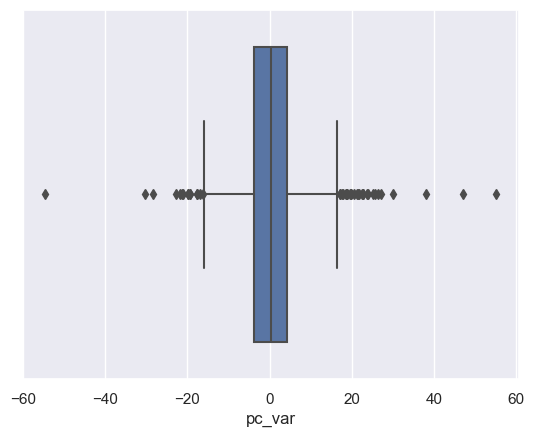

In [56]:
sns.boxplot(x=df_nb["pc_var"])

<AxesSubplot: xlabel='pc_var'>

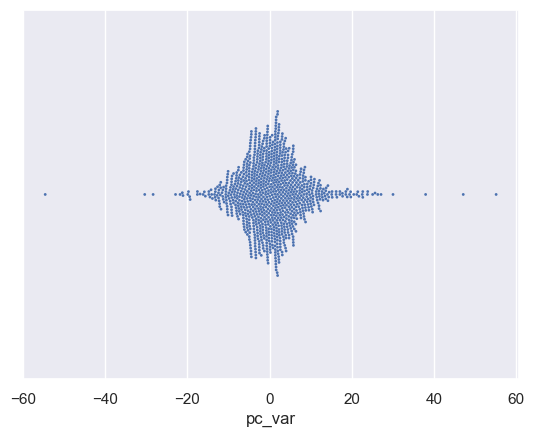

In [57]:
sns.swarmplot(x=df_nb["pc_var"], size=2)

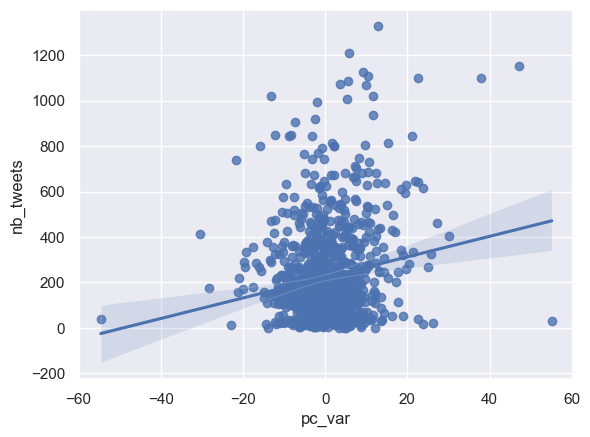

In [58]:
sns.regplot(x="pc_var", y="nb_tweets", data=df_nb);

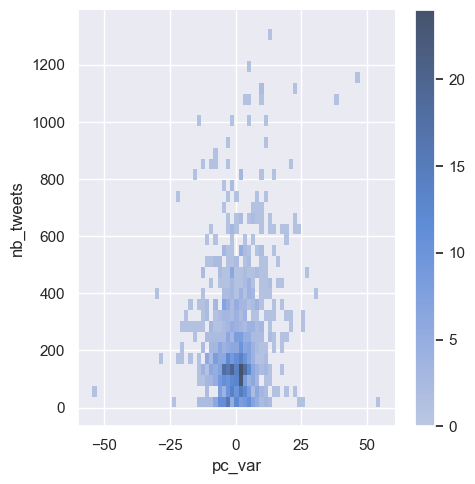

In [59]:
sns.displot(df_nb, x="pc_var", y="nb_tweets", cbar=True)

#### tweets level

In [60]:
def fun_level_nb_tweets(nb):
    return str(100*round(nb/100))
df_nb["tweet_level"] = df_nb["nb_tweets"].apply(fun_level_nb_tweets)
list_tweet_level = sorted(list(df_nb["tweet_level"].unique()), key=int)
print("list_tweet_level: ", list_tweet_level)
df_nb

list_tweet_level:  ['0', '100', '200', '300', '400', '500', '600', '700', '800', '900', '1000', '1100', '1200', '1300']


,nb_tweets,level_tweets,Date,Open,High,Low,Close,Adj Close,Volume,timestamp,pc_var,level_stat_price,level_price,tweet_level
238,2,low_nb_tweet,2019-12-30,0.030096,0.033129,0.029338,0.032726,0.032726,11037407,1.577664e+09,8.738703,bullish,surge,0
239,35,low_nb_tweet,2019-12-31,0.032700,0.038978,0.032562,0.037197,0.037197,12297226,1.577750e+09,13.752294,bullish,surge,0
240,37,low_nb_tweet,2020-01-01,0.037197,0.039687,0.034801,0.039226,0.039226,12577450,1.577837e+09,5.454741,neutral,rise,0
241,52,low_nb_tweet,2020-01-02,0.039209,0.039322,0.034053,0.034784,0.034784,10414026,1.577923e+09,-11.285674,bearish,fall,100
242,38,low_nb_tweet,2020-01-03,0.034774,0.038628,0.034186,0.036693,0.036693,11271250,1.578010e+09,5.518491,neutral,rise,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1260,156,normal_nb_tweet,2022-10-17,0.150487,0.152528,0.148830,0.152231,0.152231,4791953,1.665965e+09,1.158904,neutral,neutral,200
1261,686,high_nb_tweet,2022-10-18,0.152237,0.199573,0.151643,0.167960,0.167960,86145727,1.666051e+09,10.327975,bullish,surge,700
1262,273,normal_nb_tweet,2022-10-19,0.167924,0.167924,0.160154,0.164779,0.164779,20414280,1.666138e+09,-1.872871,neutral,neutral,300
1263,226,normal_nb_tweet,2022-10-20,0.164792,0.167368,0.162250,0.165510,0.165510,10699438,1.666224e+09,0.435701,neutral,neutral,200


In [61]:
np.sort(df_nb["tweet_level"].unique())

array(['0', '100', '1000', '1100', '1200', '1300', '200', '300', '400',
       '500', '600', '700', '800', '900'], dtype=object)

<AxesSubplot: xlabel='tweet_level', ylabel='Count'>

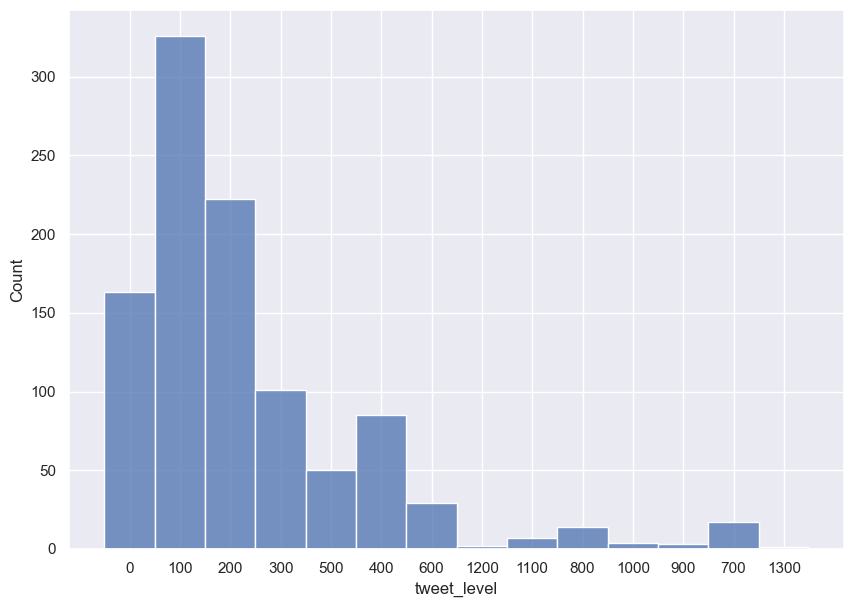

In [62]:
fig = plt.figure(figsize=(10, 7))
#ax = fig.gca()
sns.histplot(df_nb, x="tweet_level")

<AxesSubplot: xlabel='pc_var', ylabel='tweet_level'>

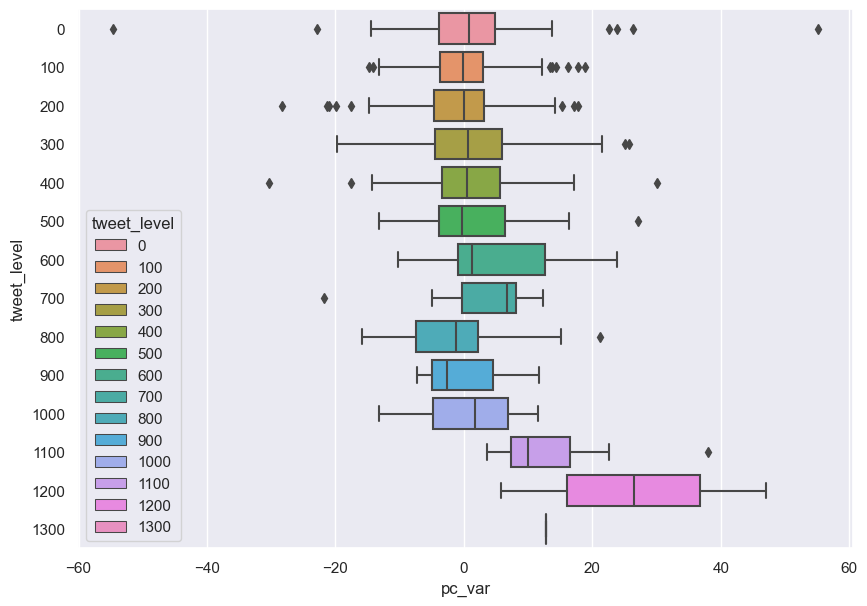

In [63]:
#sns.boxplot(data=df_nb, x="pc_var", y="level")
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df_nb, x="pc_var", y="tweet_level", 
    hue="tweet_level", dodge=False,
    order=list_tweet_level, hue_order=list_tweet_level
)


/Users/gregory/miniforge3/envs/ocean_tf_new/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 22.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot: xlabel='pc_var', ylabel='tweet_level'>

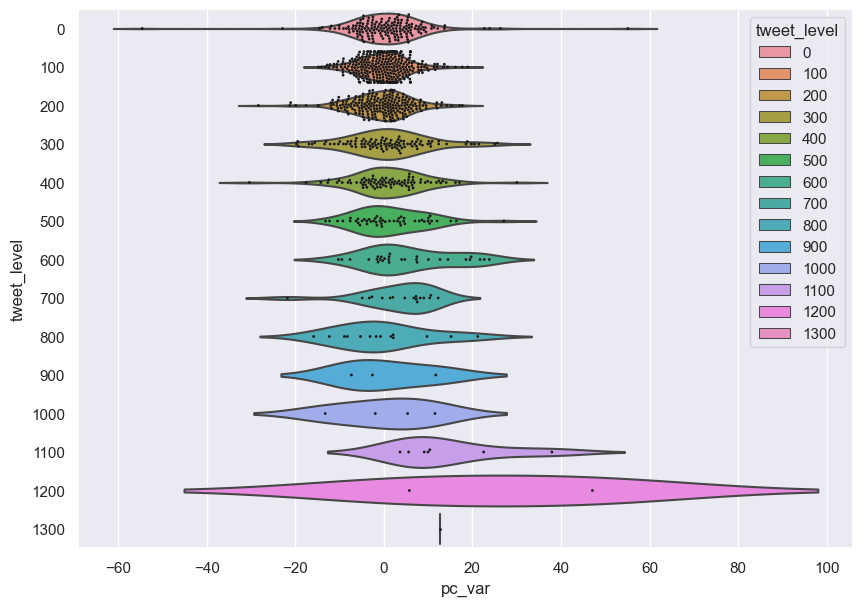

In [64]:
fig = plt.figure(figsize=(10, 7))
ax = fig.gca()
sns.violinplot(data=df_nb, x="pc_var", y="tweet_level", hue="tweet_level", 
               order=list_tweet_level, hue_order=list_tweet_level, 
               inner=None, dodge=False)
#sns.catplot(data=df_nb, x="pc_var", y="tweet_level", kind="violin", inner=None)
sns.swarmplot(data=df_nb, x="pc_var", y="tweet_level", color="k", 
              order=list_tweet_level,
              size=2, ax=ax)

#### Tweets level stat

<AxesSubplot: xlabel='level_tweets', ylabel='Count'>

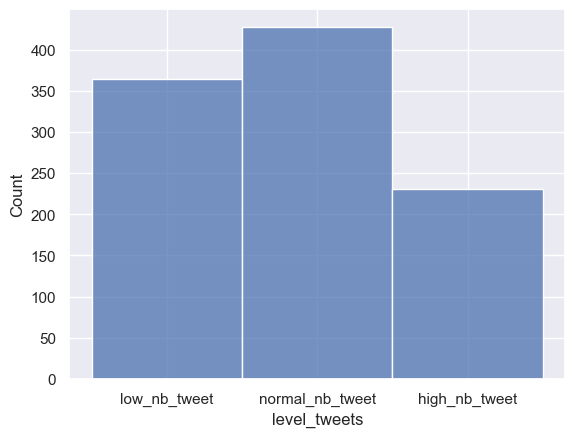

In [76]:
#fig = plt.figure(figsize=(10, 7))
#ax = fig.gca()
sns.histplot(df_nb, x="level_tweets")

<AxesSubplot: xlabel='pc_var', ylabel='level_tweets'>

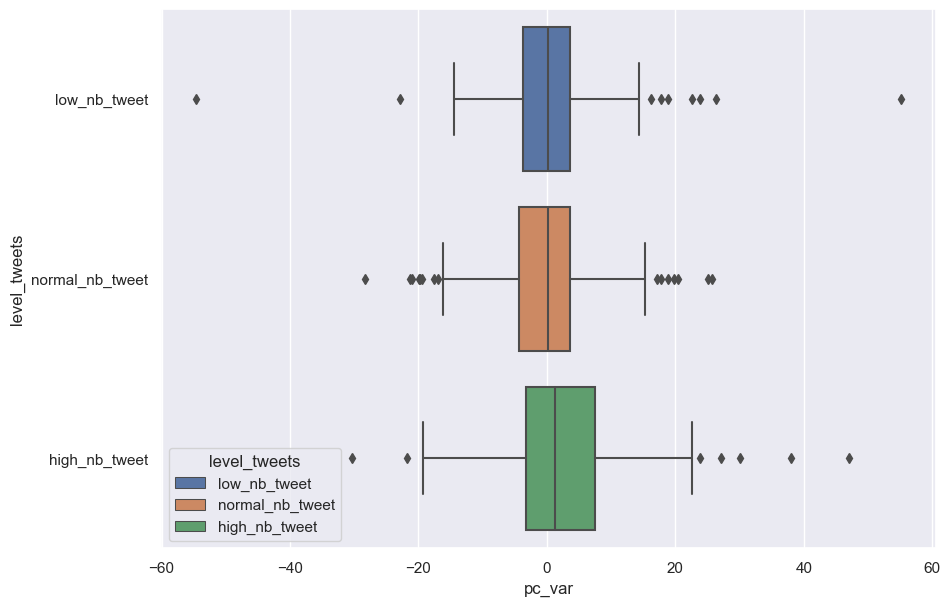

In [77]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df_nb, x="pc_var", y="level_tweets", 
    hue="level_tweets", dodge=False,
    order=list_level_tweets, hue_order=list_level_tweets
)

<AxesSubplot: xlabel='pc_var', ylabel='level_tweets'>

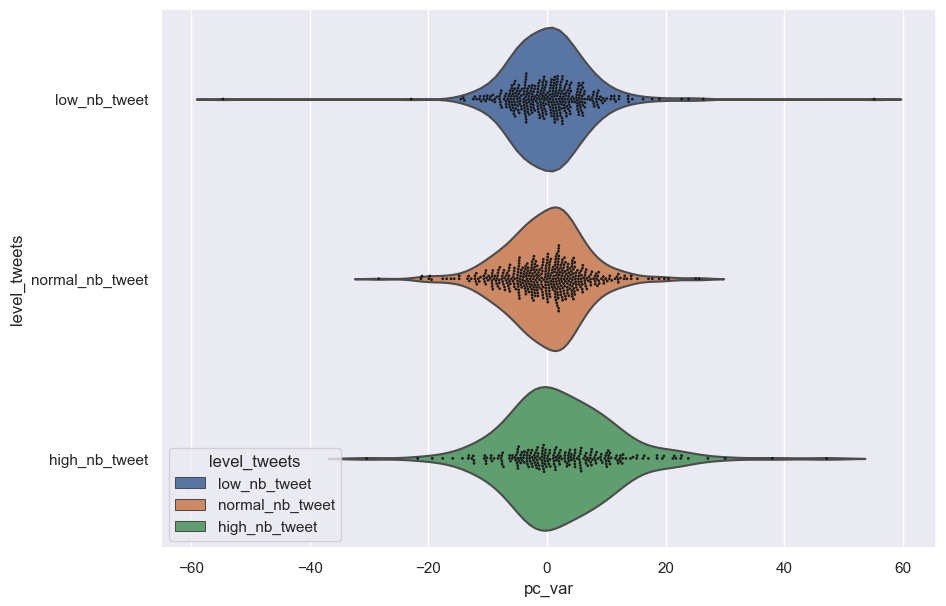

In [78]:
fig = plt.figure(figsize=(10, 7))
ax = fig.gca()
sns.violinplot(data=df_nb, x="pc_var", y="level_tweets", hue="level_tweets", 
               order=list_level_tweets, hue_order=list_level_tweets, 
               inner=None, dodge=False)
sns.swarmplot(data=df_nb, x="pc_var", y="level_tweets", color="k", 
              order=list_level_tweets,
              size=2, ax=ax)

#### price level

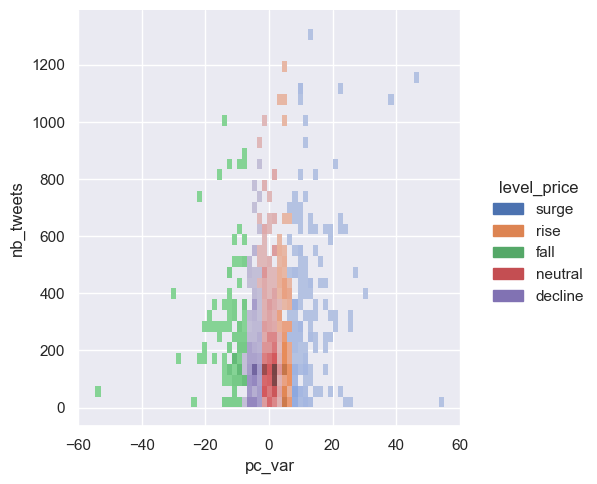

In [65]:
sns.displot(df_nb, x="pc_var", y="nb_tweets", hue="level_price")

<Figure size 1000x700 with 0 Axes>

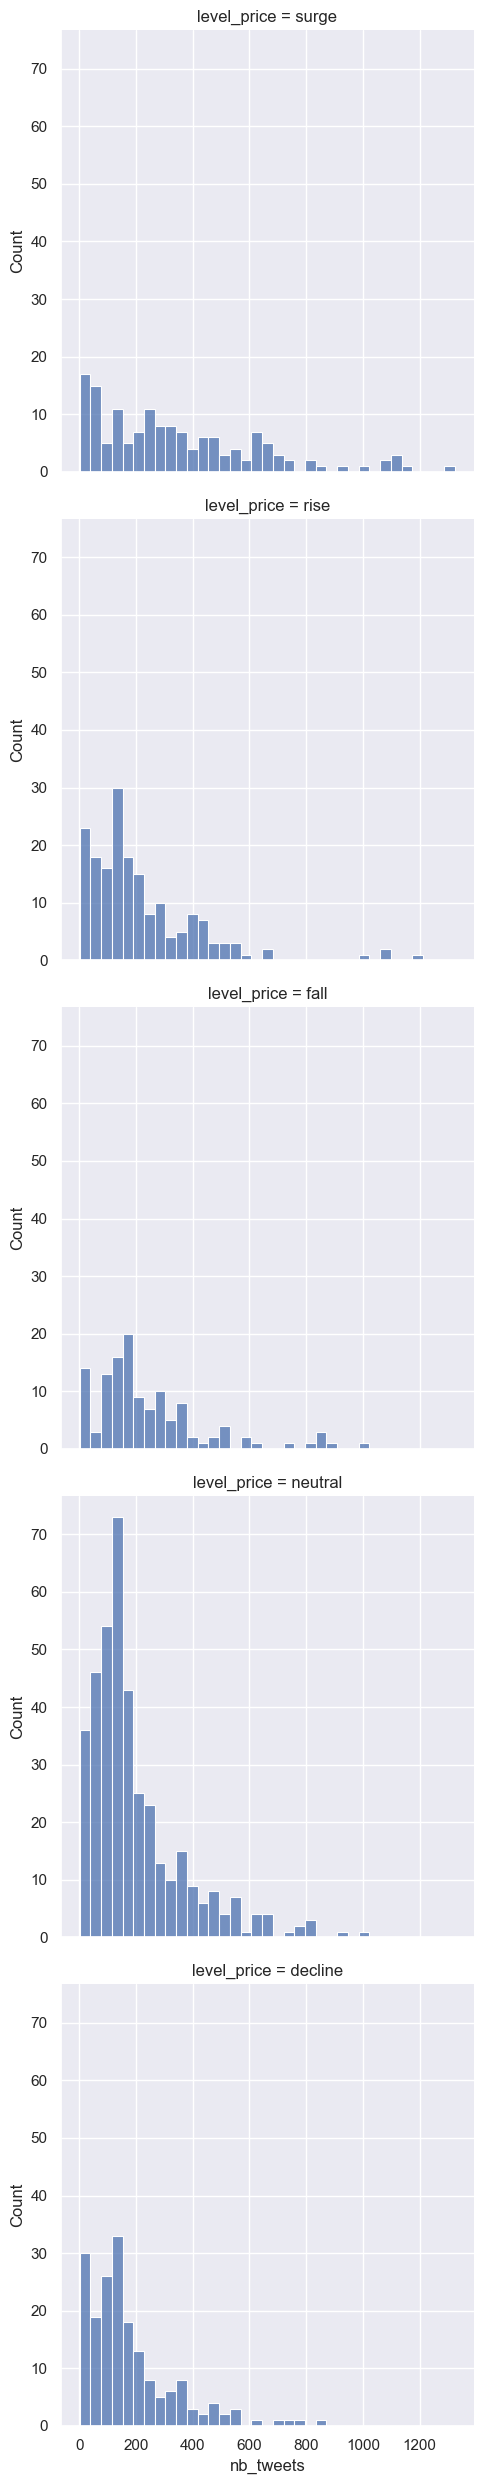

In [66]:
fig = plt.figure(figsize=(10, 7))
#ax = fig.gca()
sns.displot(df_nb, x="nb_tweets", row="level_price")

<AxesSubplot: xlabel='nb_tweets', ylabel='level_price'>

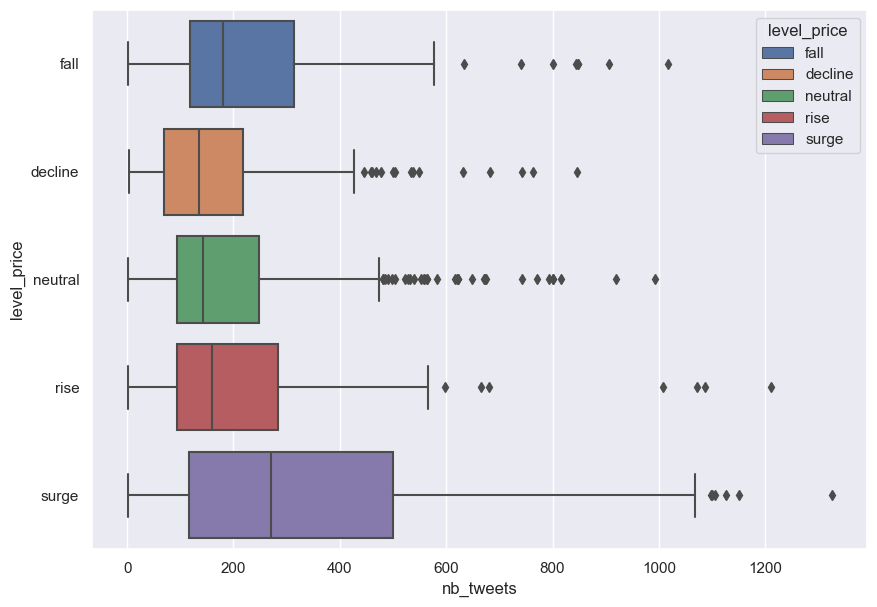

In [67]:
#sns.boxplot(data=df_nb, x="pc_var", y="level")
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df_nb, x="nb_tweets", y="level_price", 
    hue="level_price", dodge=False, 
    order=list_level_price, hue_order=list_level_price)

<AxesSubplot: xlabel='nb_tweets', ylabel='level_price'>

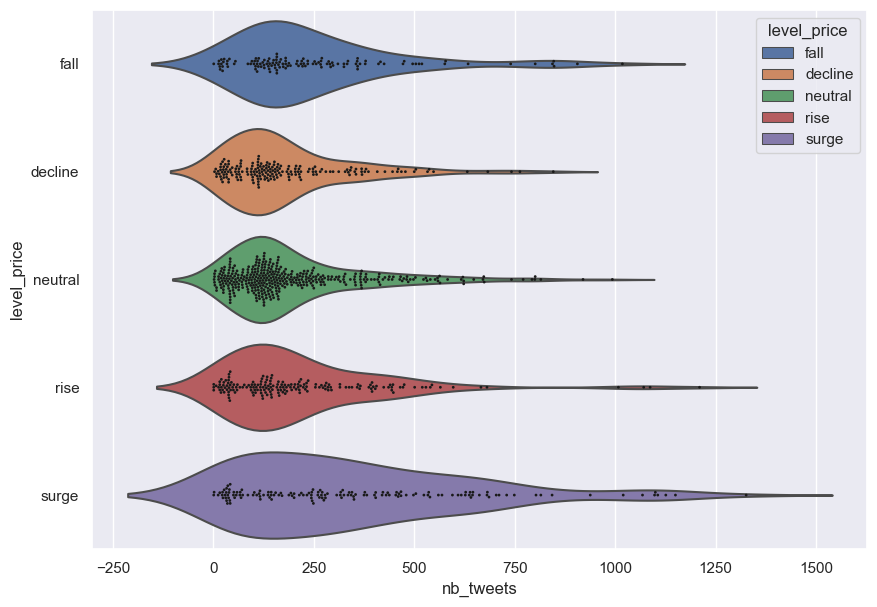

In [68]:
fig = plt.figure(figsize=(10, 7))
ax = fig.gca()
sns.violinplot(data=df_nb, x="nb_tweets", y="level_price", hue="level_price", 
               order=list_level_price, hue_order=list_level_price, 
               inner=None, dodge=False)
#sns.catplot(data=df_nb, x="pc_var", y="tweet_level", kind="violin", inner=None)
sns.swarmplot(data=df_nb, x="nb_tweets", y="level_price", color="k", 
              order=list_level_price,
              size=2, ax=ax)

<AxesSubplot: xlabel='level_price', ylabel='nb_tweets'>

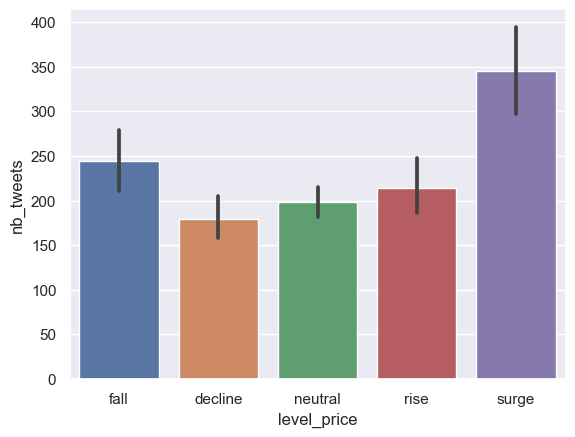

In [69]:
sns.barplot(data=df_nb, x="level_price", y="nb_tweets",
order=list_level_price)

#### price stat level 

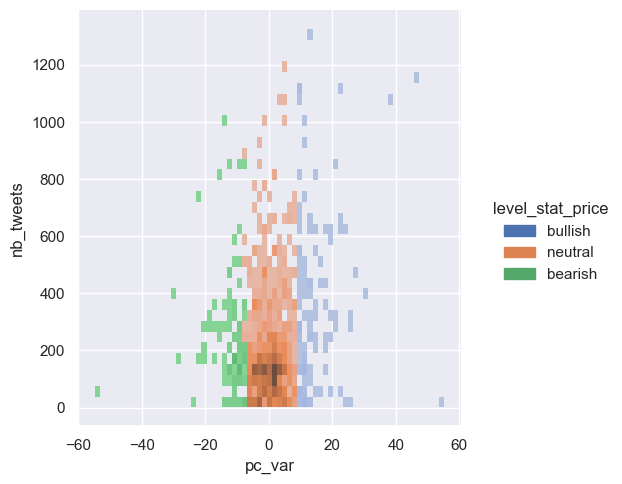

In [70]:
sns.displot(df_nb, x="pc_var", y="nb_tweets", hue="level_stat_price")

<Figure size 1000x800 with 0 Axes>

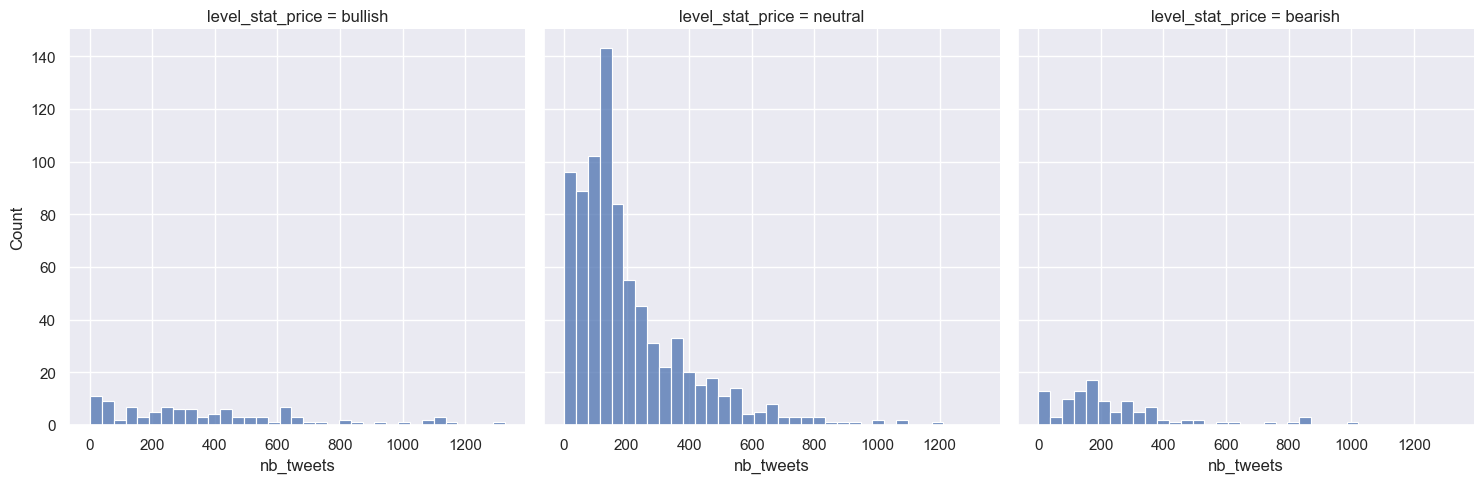

In [71]:
fig = plt.figure(figsize=(10, 8))
#ax = fig.gca()
sns.displot(df_nb, x="nb_tweets", col="level_stat_price")

<AxesSubplot: xlabel='nb_tweets', ylabel='level_stat_price'>

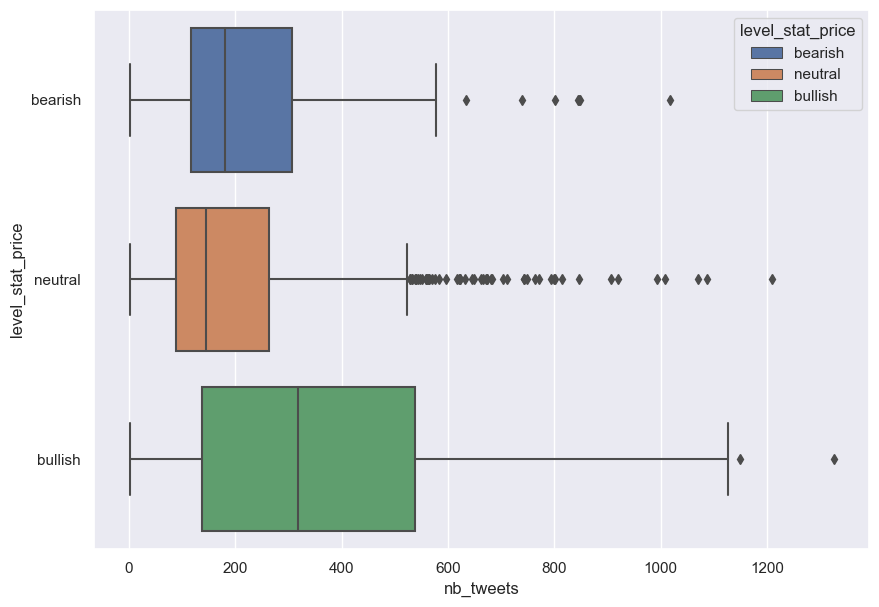

In [72]:
#sns.boxplot(data=df_nb, x="pc_var", y="level")
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df_nb, x="nb_tweets", y="level_stat_price", 
    hue="level_stat_price", dodge=False, 
    order=list_level_stat_price, hue_order=list_level_stat_price)

<AxesSubplot: xlabel='nb_tweets', ylabel='level_stat_price'>

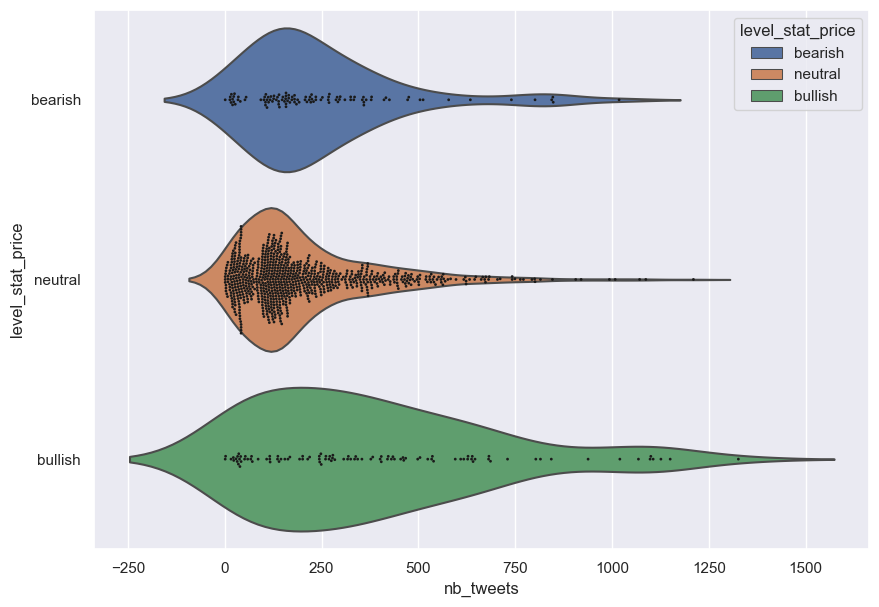

In [73]:
fig = plt.figure(figsize=(10, 7))
ax = fig.gca()
sns.violinplot(data=df_nb, x="nb_tweets", y="level_stat_price", hue="level_stat_price", 
               order=list_level_stat_price, hue_order=list_level_stat_price, 
               inner=None, dodge=False)
#sns.catplot(data=df_nb, x="pc_var", y="tweet_level", kind="violin", inner=None)
sns.swarmplot(data=df_nb, x="nb_tweets", y="level_stat_price", color="k", 
              order=list_level_stat_price,
              size=2, ax=ax)

<AxesSubplot: xlabel='level_stat_price', ylabel='nb_tweets'>

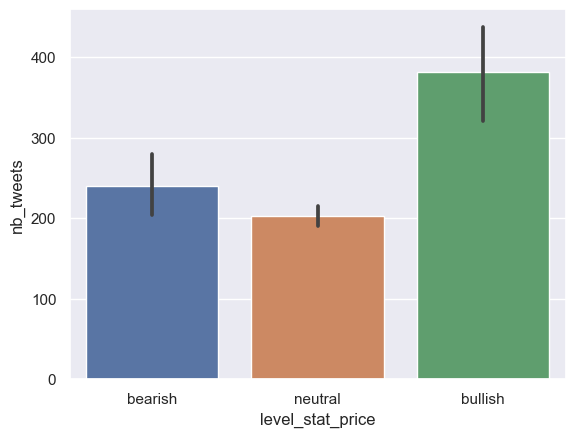

In [74]:
sns.barplot(data=df_nb, x="level_stat_price", y="nb_tweets",
order=list_level_stat_price)

- Number of tweets increase during Bearish and Bullish events (price variation)  
- More during bullish period

## Determine the correlation between the price of $OCEAN and the number of likes received by tweets containing "$OCEAN". 
What insights can be derived from this correlation?